# (1) Import req module and data

## 1.1 Import the final merged cleandata of goa

In [4]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Firepoints Data

Fianl_cleanData_Merged_Goa = pd.read_csv("/content/drive/MyDrive/BITS_PILANI_RESEARCH/Data/Final_Merge_CleanData_1Hour.csv", encoding='latin1')

/tmp/ipython-input-3797330575.py:10: DtypeWarning: Columns (21,23,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  Fianl_cleanData_Merged_Goa = pd.read_csv("/content/drive/MyDrive/BITS_PILANI_RESEARCH/Data/Final_Merge_CleanData_1Hour.csv", encoding='latin1')


## 1.2 Load the shape file of Goa

      osm_id                              name                Type State  \
0  202271962  Chorao Island (Dr.Salim Ali) WLS  Wildlife Sanctuary   Goa   

   Year  Area  feature_id                                           geometry  
0  1988  1.78          62  MULTIPOLYGON (((74.09407 15.45244, 74.10334 15...  


<Axes: >

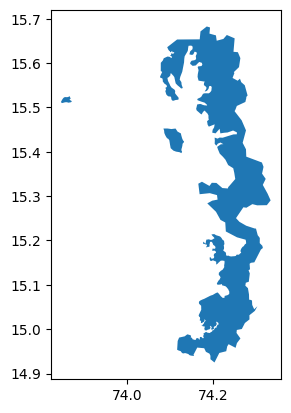

In [5]:
import geopandas as gpd

# Load the shape file
protect_area = gpd.read_file("/content/drive/MyDrive/BITS_PILANI_RESEARCH/Data/Data/shp/Protect_area.shp")

# Prview spatial data
print(protect_area.head())
protect_area.plot()

## 1.3 Drop the rendundant column

In [6]:
# Drop Forest Block, Compartment number columns

Fianl_cleanData_Merged_Goa.drop(columns=['DT_1H','DISTRICT_N','FIRE_DT_1H_x','FIRE_DT_1H_y'], inplace=True)
print(Fianl_cleanData_Merged_Goa.head())

    DISTRICT            STATION DATE(YYYY-MM-DD) TIME (UTC)  \
0  NORTH_GOA  ELA_NORTH GOA_KVK       2021-10-01   00:00:00   
1  NORTH_GOA  ELA_NORTH GOA_KVK       2021-10-01   00:15:00   
2  NORTH_GOA  ELA_NORTH GOA_KVK       2021-10-01   00:30:00   
3  NORTH_GOA  ELA_NORTH GOA_KVK       2021-10-01   00:45:00   
4  NORTH_GOA  ELA_NORTH GOA_KVK       2021-10-01   01:00:00   

   RAIN FALL CUM. SINCE 0300 UTC (mm)  TEMP. ('C)  TEMP DAY MIN. ('C)  \
0                                 0.0        25.0                24.7   
1                                 0.0        24.8                24.7   
2                                 0.0        24.7                24.7   
3                                 0.0        24.8                24.7   
4                                 0.0        25.0                24.7   

   TEMP DAY MAX. ('C)  RH (%)  WIND DIR 10 m (Deg)  ...  Lat_AWS  Long_AWS  \
0                32.0   100.0                 75.0  ...  15.4893   73.9196   
1                32.0   10

# (2) Implement ML Model

## 2.1 Splitting data

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the final table (use in-memory if present, else CSV)
df = Fianl_cleanData_Merged_Goa.copy()

# Safety check
assert "fire_occurrence" in df.columns, "Label column 'fire_occurrence' not found"

# y: target
y = df["fire_occurrence"].astype(int)

# X: all numeric features except the label
# This automatically ignores textual columns like station, district, circle, etc.
X_num = df.select_dtypes(include=["number"]).copy()
if "fire_occurrence" in X_num.columns:
    X_num = X_num.drop(columns=["fire_occurrence"])

# Report class balance before split
print("Total rows:", len(df))
print("Label distribution:\n", y.value_counts(dropna=False))

# First split: 60% train, 40% temp (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_num, y, test_size=0.40, stratify=y, random_state=42, shuffle=True
)

# Second split: temp -> 20% val, 20% test (50/50 split of temp, stratified)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42, shuffle=True
)

# Show shapes and class balance
def info_split(name, Xp, yp):
    print(f"{name}: X={Xp.shape}, y={yp.shape}")
    print(f"{name} label distribution:\n", yp.value_counts(dropna=False))

info_split("Train", X_train, y_train)
info_split("Validation", X_val, y_val)
info_split("Test", X_test, y_test)

Total rows: 328559
Label distribution:
 fire_occurrence
0    327757
1       802
Name: count, dtype: int64
Train: X=(197135, 16), y=(197135,)
Train label distribution:
 fire_occurrence
0    196654
1       481
Name: count, dtype: int64
Validation: X=(65712, 16), y=(65712,)
Validation label distribution:
 fire_occurrence
0    65551
1      161
Name: count, dtype: int64
Test: X=(65712, 16), y=(65712,)
Test label distribution:
 fire_occurrence
0    65552
1      160
Name: count, dtype: int64


## 2.2 Model Selection

In [8]:
import copy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

# Random Forest with class balancing and warm_start for incremental training
rf = RandomForestClassifier(
    n_estimators=0,                # will grow trees iteratively
    criterion="log_loss",         # probabilistic criterion for classification
    class_weight="balanced_subsample",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
    warm_start=True               # allow adding trees across epochs
)

model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # RF cannot handle NaNs directly
    ("rf", rf)
])

# Early stopping config
max_epochs = 30                  # requested number of runs
trees_per_epoch = 10             # trees added per epoch (total up to 300)
patience = 5                     # stop if no improvement for 'patience' epochs
min_delta = 1e-4                 # minimum AP improvement to reset patience

best_ap = -np.inf
best_epoch = -1
epochs_without_improve = 0
best_model = None

for epoch in range(1, max_epochs + 1):
    # Increase the number of trees
    model.named_steps["rf"].n_estimators += trees_per_epoch

    # Fit on training data (imputer fits on train only inside the pipeline)
    model.fit(X_train, y_train)

    # Evaluate on validation with Average Precision (PR AUC) for imbalanced data
    val_proba = model.predict_proba(X_val)[:, 1]
    ap = average_precision_score(y_val, val_proba)

    print(f"Epoch {epoch:02d} | n_estimators={model.named_steps['rf'].n_estimators} | Val AP={ap:.6f}")

    # Early stopping check
    if ap > best_ap + min_delta:
        best_ap = ap
        best_epoch = epoch
        best_model = copy.deepcopy(model)  # snapshot the current best model
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve >= patience:
            print(f"Early stopping at epoch {epoch} (best at epoch {best_epoch} with AP={best_ap:.6f})")
            break

# Use the best snapshot for downstream steps
rf_model = best_model if best_model is not None else model
print(f"Training complete. Best epoch={best_epoch}, Best Val AP={best_ap:.6f}")

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 01 | n_estimators=10 | Val AP=1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 02 | n_estimators=20 | Val AP=1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 03 | n_estimators=30 | Val AP=1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 04 | n_estimators=40 | Val AP=1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 05 | n_estimators=50 | Val AP=1.000000


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


Epoch 06 | n_estimators=60 | Val AP=1.000000
Early stopping at epoch 6 (best at epoch 1 with AP=1.000000)
Training complete. Best epoch=1, Best Val AP=1.000000


## 2.3 Print the accuracy of model

In [9]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss, log_loss,
    mean_squared_error, r2_score
)

# Probabilities and class predictions
val_proba = rf_model.predict_proba(X_val)[:, 1]
test_proba = rf_model.predict_proba(X_test)[:, 1]

val_pred = (val_proba >= 0.5).astype(int)
test_pred = (test_proba >= 0.5).astype(int)

def print_metrics(split_name, y_true, y_pred, y_proba):
    # Core classification metrics for imbalanced data
    acc  = accuracy_score(y_true, y_pred)
    bal  = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    ap   = average_precision_score(y_true, y_proba)

    # Calibration- and error-like quantities on probabilities
    brier = brier_score_loss(y_true, y_proba)
    ll    = log_loss(y_true, np.vstack([1 - y_proba, y_proba]).T, labels=[0, 1])

    # Regression-style errors on probability targets (non-standard but informative)
    mse  = mean_squared_error(y_true, y_proba)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_proba)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    print(f"\n=== {split_name} Metrics ===")
    print(f"Accuracy:               {acc:.6f}")
    print(f"Balanced Accuracy:      {bal:.6f}")
    print(f"Precision (pos=1):      {prec:.6f}")
    print(f"Recall (pos=1):         {rec:.6f}")
    print(f"F1 (pos=1):             {f1:.6f}")
    print(f"ROC AUC:                {roc:.6f}")
    print(f"Average Precision (AP): {ap:.6f}")
    print(f"Brier score (prob):     {brier:.6f}")
    print(f"Log loss:               {ll:.6f}")
    print(f"MSE (prob vs label):    {mse:.6f}")
    print(f"RMSE (prob vs label):   {rmse:.6f}")
    print(f"R2 (prob vs label):     {r2:.6f}")
    print("Confusion Matrix [rows=true 0/1, cols=pred 0/1]:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=6, zero_division=0))

# Print for Validation and Test
print_metrics("Validation", y_val, val_pred, val_proba)
print_metrics("Test",       y_test, test_pred, test_proba)



=== Validation Metrics ===
Accuracy:               1.000000
Balanced Accuracy:      1.000000
Precision (pos=1):      1.000000
Recall (pos=1):         1.000000
F1 (pos=1):             1.000000
ROC AUC:                1.000000
Average Precision (AP): 1.000000
Brier score (prob):     0.000007
Log loss:               0.000052
MSE (prob vs label):    0.000007
RMSE (prob vs label):   0.002588
R2 (prob vs label):     0.997260
Confusion Matrix [rows=true 0/1, cols=pred 0/1]:
[[65551     0]
 [    0   161]]

Classification report:
              precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000     65551
           1   1.000000  1.000000  1.000000       161

    accuracy                       1.000000     65712
   macro avg   1.000000  1.000000  1.000000     65712
weighted avg   1.000000  1.000000  1.000000     65712


=== Test Metrics ===
Accuracy:               1.000000
Balanced Accuracy:      1.000000
Precision (pos=1):      1.000000
Recall (pos=1):         